In [178]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using PyPlot
using MAT
using JLD2

include("./readers.jl")
using .ShipPosmv

# helper functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

  Activating project at `~/Projects/ASTRAL/lidar`


m2n (generic function with 1 method)

In [127]:
# timing functions

# Define the GPS epoch
const GPS_EPOCH = DateTime(1980, 1, 6) # DateTime
# const GPS_OFFSET = Dates.datetime2epochms(GPS_EPOCH) # Integer time interval since DateTime epoch

# Function to calculate the number of leap seconds between two dates
function leap_seconds(date::DateTime)
    leap_seconds_list = [
        DateTime(1981, 7, 1), DateTime(1982, 7, 1), DateTime(1983, 7, 1),
        DateTime(1985, 7, 1), DateTime(1988, 1, 1), DateTime(1990, 1, 1),
        DateTime(1991, 1, 1), DateTime(1992, 7, 1), DateTime(1993, 7, 1),
        DateTime(1994, 7, 1), DateTime(1996, 1, 1), DateTime(1997, 7, 1),
        DateTime(1999, 1, 1), DateTime(2006, 1, 1), DateTime(2009, 1, 1),
        DateTime(2012, 7, 1), DateTime(2015, 7, 1), DateTime(2017, 1, 1)
    ]
    return count(ls -> ls <= date, leap_seconds_list)
end

# "convert gpstime (nanoseconds) to DateTime"
# function gps2dt(gpstime::Integer)
#     t_d = floor(gpstime / (86_400 * 1_000_000_000)) # nanosecond -> integer day
#     t_ms = round(Int64, (gpstime % (86_400 * 1_000_000_000) ) / 1_000_000 - 1_000*leap_seconds(t_d)) # nansecond -> millisecond of day
#     GPS_EPOCH + Day(t_d) + Millisecond(t_ms)
# end

"convert gpstime (nanoseconds) to DateTime."
function gps2dt(gpstime::Integer)
    # leap seconds not needed when using time elapsed
    # Millisecond(Integer) -> millisecond timedelta
    GPS_EPOCH + Millisecond(round(Int64, gpstime / 1_000_000))
end

"convert gpstime (nanoseconds) to DateTime epoch milliseconds (integer)."
function gps2ms(gpstime::Integer)
    round(Int64, gpstime / 1_000_000 ) + Dates.datetime2epochms(GPS_EPOCH)
end

dt2gpsns(dt) = Dates.value(Millisecond( dt-GPS_EPOCH )) * 1_000_000 # -> Integer
GPS_MORETHAN = dt2gpsns(DateTime(2024,1,1))

# tests
Dates.datetime2epochms(DateTime(0)) # 0 OK
Dates.epochms2datetime( Dates.datetime2epochms(GPS_EPOCH) ) # 1980-01-06T00:00:00 OK
gps2dt( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) ) # 2024-04-29T05:25:42.128 OK
DateTime(0) + Millisecond(gps2ms( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) )) # 2024-04-29T05:25:42.128 OK
DateTime(0) + Millisecond( 63881587542128 ) # # 2024-04-29T05:25:42.128 OK
gps2ms( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) ) # 63881587542128 OK

"""
itp(dtq) = interpolatedt(dtk, xk, Gridded(Linear()))(Dates.datetime2epochms(dtq))
interpolate using datetimes as coordinates
"""
interpolatedt(dt, x...) = interpolate(Dates.datetime2epochms(dt), x...)

"short wrapper for Dates.value(Millisecond(t))"
DVM(t::TimePeriod) = Dates.value(Millisecond(t))
DVM(t::Integer) = Dates.value(Millisecond(t))
DVM(t::Real) = DVM(round(Int64,t))
DVM(t::AbstractVector{T}) where T<:TimePeriod = DVM.(t)
function DVM(dt::DateTime)
    error("do not use DVM(::DateTime)")
end

"""
Interpolate between imprecisely recorded jumps in time.
Need Float64 precision for interpolation
"""
function intbetweentime(prectime::Vector{Float64})
    # monotonic, OK
    ii0 = map(x-> x<=0, diff(prectime)) 
    # ind0 = boolean 1 for imprecise times that should be interpolated
    ind0 = [0; findall(ii0)] .+ 1   # interpolate to these, increment because of diff()
    ind1 = findall(.!ii0) .+ 1 # interpolate from these

    # interpolate (and extrapolate) the inbetween times
    itp = extrapolate( 
            interpolate((ind1,), prectime[ind1], Gridded(Linear())), 
            Line() )
    # fltind0 = filter(i-> i>ind1[1] && i<ind1[end], ind0)
    # prectime[fltind0] = itp(fltind0)
    prectime[ind0] .= itp(ind0)
    # or just just reinterp all indices
    # prectime = itp(axes(prectime))
    return prectime
end

# methods for averaging DateTimes and TimePeriod
"meandt(dt, ...)"
function meandt(dt::AbstractVector{DateTime}, args...)
    ms = @. Dates.value(Millisecond(dt - dt[1]))
    return dt[1] .+ Millisecond(round(Int64, mean(ms, args...)))
end
"meandt(t, ...)"
function meandt(dt::AbstractVector{T}, args...) where T<:TimePeriod    ms = @. Dates.value(Millisecond(dt))
    return Millisecond(round(Int64, mean(ms, args...)))
end

"interpolate and add offsets to DateTime of precise time from vectornav."
function precise_dt(vn_raw_dt, gpstime)
    RASP_BASE_TIME = floor(vn_raw_dt[1], Dates.Day(1)) # totally bogus unset offset clock time
    # need Float64 precision for interpolation
    # RASP_BASE_TIME is a datetime before the start of the data.
    
    # add offsets
    prectime = intbetweentime( Float64.(DVM( vn_raw_dt .- RASP_BASE_TIME )) )
    precdt_vn_clock = RASP_BASE_TIME .+ Dates.Millisecond.(round.(Int64, prectime))
    offset_gps_vn = gps2dt(gpstime[1]) - precdt_vn_clock[1] # OK for leg 1
    precdt = precdt_vn_clock + offset_gps_vn # move to absolute GPS clock
    return precdt
    # next linearly stretch to minimize bias from GPS
end

"""
Stretch VectorNav millisecond-interpolated
time linearly to match best GPS times at 
the start and 0-1 minute after the reset.
"""
function stretch_vn_to_gps(precdt, gpstime)
    i0 = 2 # step starting good GPS times
    ir = iregress(gpstime)[1]+1 # step after GPS reset
    # delta = meandt(gps2dt.(gpstime[ir:(ir+1200)])) - meandt(precdt[ir:(ir+1200)])
    delta = meandt(gps2dt.(gpstime[ir:(ir+200)])) - meandt(precdt[ir:(ir+200)])
    buildup = range(start=0, length=length(precdt), step=DVM(delta)/(ir+600))
    vntime = @. precdt + Millisecond(round(Int64,buildup))
    return vntime # DateTime
end

"shift, interp, and stretch a time axis to match the GPS"
time2vndt(time, gpstime) = stretch_vn_to_gps( precise_dt(time, gpstime), gpstime )

# POSMV timing

"convert the GPS time from the POSMV PASHR message to a DateTime"
function pashr_gps_datetime(pashrtime, gpstime)
    gps_diff_12 = Millisecond(gpstime - (Time(pashrtime) - Hour(12)))
    gps_diff = mod(gps_diff_12, Day(1)) - Hour(12)
    gpsdt = pashrtime + gps_diff
    #DateTime(Date(pashrtime)) 
       #  + ( Millisecond.(gpstime - Time(pashrtime))
end

pashr_gps_datetime

In [3]:
# Concatenate variables from two Dicts into 1 Dict

"""
Concatenate Array variables from two Dicts into one
along the dimension dim
that are values of the same key of dict1 and dict2.
"""
function cat_dicts(dict1::Dict, dict2::Dict; dim=1)
    result_dict = typeof(dict1)()
    for key in intersect( keys(dict1), keys(dict2) )
        result_dict[key] = cat(dict1[key], dict2[key], dims=dim)
    end
    return result_dict
end

cat_dicts

from file: `vectornav.h`

```
#define IDX_TIMEGPS 0
#define IDX_YAW 1
#define IDX_PITCH 2
#define IDX_ROLL 3
#define IDX_QUAT0 4
#define IDX_QUAT1 5
#define IDX_QUAT2 6
#define IDX_QUAT3 7
#define IDX_LATITUDE 8
#define IDX_LONGITUDE 9
#define IDX_ALTITUDE 10
#define IDX_MAGNED0 11
#define IDX_MAGNED1 12
#define IDX_MAGNED2 13
#define IDX_LINACC0 14
#define IDX_LINACC1 15
#define IDX_LINACC2 16
#define IDX_VELNED0 17
#define IDX_VELNED1 18
#define IDX_VELNED2 19
```

```
from file:  vectornav.cpp

  shared_memory->name(
    "GpsTime",
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2");
```
To decode these variables, you need to look at the VectorNav variable description located in \ceees-lidar-platform-master\lib-src\vnproglib-1.1\index.html
under sensor class.

In [4]:
# function to read the VectorNav file
# line:
# Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
#
# 21 science data fields delimited by commas

function read_vecnav_data( file::AbstractString )
    # allocate arrays
    nlmax = countlines(file)
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read it     >>BLACK PUMAS<<
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    open( file ) do f
        for line in readlines(f)
            # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
            nl += 1
            spl = split(line, r"[\ ,]+")
            try
                dt[nl] = ( 
                    DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                  + Year(parse(Int16, spl[5])-1) 
                  +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                intdata[nl,:] .= parse.(Int64, spl[6:7])  #  2
                data[nl,:] .= parse.(Float32, spl[8:end]) # 19
            catch
                @show line
            end
        end
    end

    # trim uninitialized times off the start
    # i0 = findfirst(diff(intdata[1:nl,2]) .> 1e17) + 1 # broken
    i0 = findfirst(intdata[1:nl,2] .> GPS_MORETHAN)
    return dt[i0:nl], intdata[i0:nl,:], data[i0:nl,:]
end

function read_vecnav_data( files::AbstractVector )
    # allocate arrays
    nlmax = sum( countlines.(files) )
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read files
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    for file in files
        open( file ) do f
            for line in readlines(f)
                # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
                spl = split(line, r"[\ ,]+")
                try
                    id = parse.(Int64, spl[6:7])
                    if id[2] > GPS_MORETHAN  # use only initialized GPS times
                        nl += 1 # get data
                        dt[nl] = ( 
                            DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                        + Year(parse(Int16, spl[5])-1) 
                        +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                        intdata[nl,:] .= id                       #  2
                        data[nl,:] .= parse.(Float32, spl[8:end]) # 19
                    end
                catch
                    @show line
                end
            end
        end
    end

    return dt[1:nl], intdata[1:nl,:], data[1:nl,:]
end

function read_vecnav_dict( file )

    D = Dict{Symbol, Any}()
    vnkeys = Symbol.( [
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2" ] )

    dt, gpstime, data = read_vecnav_data( file )

    D[:time] = dt
    D[:GpsTime] = gpstime[:,2]
    for (i,k) in enumerate(vnkeys)
        D[k] = data[:,i]
    end
    return D
end


read_vecnav_dict (generic function with 1 method)

In [5]:
# precompile reader on a short file
test = read_vecnav_dict( joinpath(homedir(), "Data/EKAMSAT/lidar/table/VNshort1.txt") )
test = read_vecnav_dict( joinpath.(homedir(), ["Data/EKAMSAT/lidar/table/VNshort1.txt", "Data/EKAMSAT/lidar/table/VNshort1.txt"]) )

Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.043534, 0.062698, -0.041559, -0.03164, 0.031825, 0.0…
  :Roll      => Float32[-0.780784, -0.790312, -0.781088, -0.777058, -0.783006, …
  :Latitude  => Float32[13.0976, 13.0976, 13.0976, 13.0976, 13.0976, 13.0976, 1…
  :Yaw       => Float32[-112.49, -112.493, -112.492, -112.492, -112.497, -112.4…
  :time      => [DateTime("2023-04-13T17:52:26"), DateTime("2023-04-13T17:52:26…
  :VelNED1   => Float32[-0.929578, -0.92936, -0.930008, -0.93167, -0.933288, -0…
  :MagNED2   => Float32[-0.000821, 0.000394, -0.002465, -0.003809, -0.002429, -…
  :Altitude  => Float32[-73.516, -73.516, -73.558, -73.558, -73.558, -73.558, -…
  :Quat1     => Float32[-0.006186, -0.006244, -0.006185, -0.006155, -0.006181, …
  :VelNED2   => Float32[-0.123936, -0.125934, -0.120925, -0.122639, -0.123952, …
  :MagNED0   => Float32[0.779133, 0.782021, 0.782537, 0.78498, 0.783088, 0.7781…
  :Quat0     => Float32[0.003006, 0.003069, 0.003013, 0.002994, 0.003049, 

In [6]:
# read whole leg 1 VectorNav data file
datadir = joinpath(homedir(), "Data/EKAMSAT/lidar/table/")
file = joinpath(datadir, "leg1", "VectorNavTableData.txt")
@time Vn1 = read_vecnav_dict( file ) # 104 s
gps2dt.(Vn1[:GpsTime][[1,end]])
# start and end of the leg 1 VectorNav file GPS time

 88.059064 seconds (730.31 M allocations: 73.196 GiB, 12.38% gc time)


2-element Vector{DateTime}:
 2024-04-29T05:25:42.128
 2024-05-14T10:00:33.009

In [7]:
# find regressing GPS times (those that go backward)
iregress(gpstime) = findall(x-> x<0, diff(gpstime))
# ba(ii) = map( i->i.+[0,1], ii)[:] # ind before and after backward step
ba(ii) = (ii.+[0; 1])[:]
dtregress(gpstime) = gps2dt.( gpstime[ ba(iregress(gpstime)) ] )

[ dtregress(Vn1[:GpsTime]), # 2024-05-13T03:58:44.472 near end of leg 1
  dtregress(Vn1[:GpsTime]) ]# 2024-06-10T12:58:44.806 near end of leg 2
gps2dt.(Vn1[:GpsTime][iregress(Vn1[:GpsTime]).+[0,1]])

2-element Vector{DateTime}:
 2024-05-13T03:58:44.472
 2024-05-13T03:58:44.364

The times the GPS obviously resets are on nearly the last day of each leg.
This suggests that the times at start and end of each leg are accurate. Times late in the leg but before the reset are 
proably not as accurate.

In [10]:
# Vn datetime is reported only to the nearest second,
# so interpolate the timesteps in between.

# median(Dates.value.(Millisecond.(diff(Vn2[:time]))))
# Vn2[:time][41:50] # only precise to nearest second!

# adding RASP_OFFSET to Vn[:time] matches first time to 
# 00Z day of Vn[:time][1], i.e., to nearest day.
# more precise than using a faraway epoch offset
# BASE_TIME must be BEFORE time[1]
# RASP_BASE_TIME1 = floor(Vn2[:time][1], Dates.Day(1)) # totally bogus unset offset clock time
# # need Float64 precision for interpolation
# # RASP_OFFSET1 is a datetime before the start of the data.
# prectime = intbetweentime( Float64.(DVM( Vn2[:time] .- RASP_BASE_TIME1 )) )
# # milliseconds since 00Z of RASP_BASE_TIME1.

# # OK: Millisecond(x::Integer) --> TimePeriod as intended, but 
# # Millisecond(dt::DateTime) has a completely differnt behavior, taking the
# # milliseconds position on the clock of the dt, rather than a TimePeriod of milliseconds!
# precdt_vn_clock = RASP_BASE_TIME1 .+ Dates.Millisecond.(round.(Int64, prectime))
# offset_gps_vn = gps2dt(Vn2[:GpsTime][1]) - precdt_vn_clock[1] # OK for leg 1
# precdt = precdt_vn_clock + offset_gps_vn # move to absolute GPS clock

precdt1 = precise_dt(Vn1[:time], Vn1[:GpsTime])
# # linear time coordinate with minimal bias compared to GPS
# vndt1 = stretch_vn_to_gps(precdt, Vn1[:GpsTime])

"convenience wrapper for making a nice time axis from time and gpstime"
f(D::Dict) = time2vndt( D[:time], D[:GpsTime] )
vndt1 = f( Vn1 )

# test agreement:
[precdt1[1:5], gps2dt.(Vn1[:GpsTime][1:5])]

2-element Vector{Vector{DateTime}}:
 [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25:42.178"), DateTime("2024-04-29T05:25:42.228"), DateTime("2024-04-29T05:25:42.278"), DateTime("2024-04-29T05:25:42.328")]
 [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25:42.166"), DateTime("2024-04-29T05:25:42.235"), DateTime("2024-04-29T05:25:42.278"), DateTime("2024-04-29T05:25:42.341")]

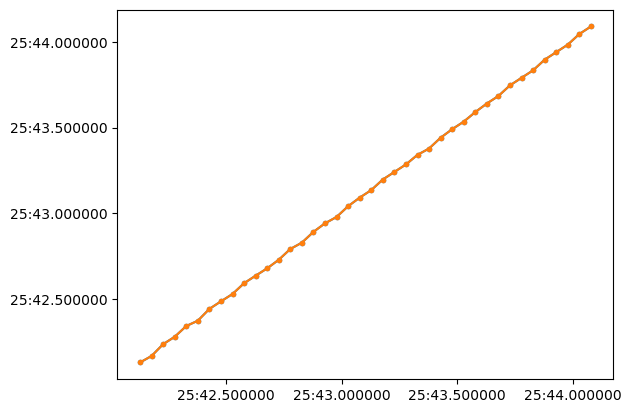

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3396b6920>

In [12]:
# test
plot(precdt1[1:40], gps2dt.(Vn1[:GpsTime][1:40]), marker=".")
plot(vndt1[1:40], gps2dt.(Vn1[:GpsTime][1:40]), marker=".")

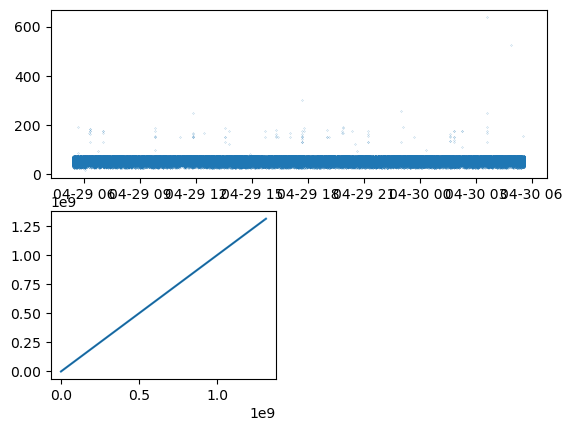

4130.9869978341985

In [14]:
# early tests

# plot(precdt[1:200:end], gps2dt.(Vn2[:GpsTime][1:200:end]), marker=".", markersize=0.1, linestyle="none")
# agrees grossly
subplot(2,1,1)
plot(precdt1[1:20*86400][1:end-1], DVM(diff(gps2dt.(Vn1[:GpsTime][1:20*86400]))),
     marker=".", markersize=0.25, linestyle="none")
# mostly 50 ms timesteps

subplot(2,2,3)
plot(DVM(precdt1[1:200:end] .- precdt1[1]), 
     DVM(gps2dt.(Vn1[:GpsTime][1:200:end]) .- gps2dt(Vn1[:GpsTime][1])) )
plot([0,1.3e9], [0,1.3e9], color="k", linewidth=0.1)

#  DVM(TimePeriod) works; but does not work on absolute dt
1 - DVM(precdt1[end] .- precdt1[1]) / DVM(gps2dt.(Vn1[:GpsTime][end]) .- gps2dt(Vn1[:GpsTime][1]))
# 1-ratio of elapsed time of 2.6e-6 indicates good agreement between the
# clocks of the Raspberry Pi and VectorNav.
DVM(precdt1[end] .- precdt1[1]) * (1 - DVM(precdt1[end] .- precdt1[1]) / DVM(gps2dt.(Vn1[:GpsTime][end]) .- gps2dt(Vn1[:GpsTime][1])))
# GPS clock gets ahead of Pi time by 3.9 s on leg 1 
# over a total elapsed time of 15.2 days.
# This is a noticeable shift, of about
# 1/2 a wave period, from the start to the end of the leg.
# 
# Assume the mean GPS time is accurate, but there is much greater jitter
# from the GPS due to its clock setting, the VectorNav polling, sampling, 
# sending, and then the Pi receiving and logging it.

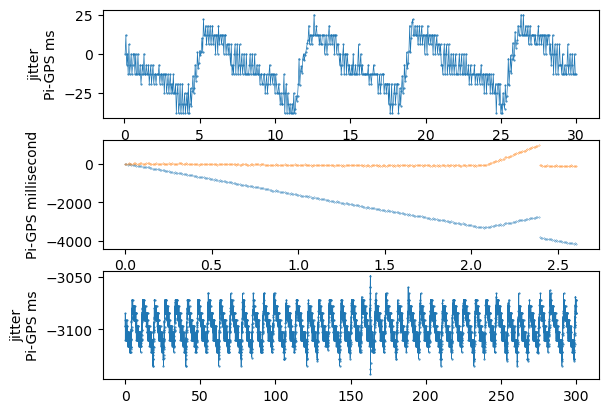

PyObject Text(40.2, 0.5, 'jitter\nPi-GPS ms')

In [16]:
# test plots of timing
clf()
subplot(3,1,1)
plot((1:600)/20, DVM(precdt1[1:600] .- gps2dt.(Vn1[:GpsTime][1:600])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")

subplot(3,1,2)
rr = 1:(20*3600):length(vndt1)
plot(rr, DVM(precdt1[rr] .- gps2dt.(Vn1[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
plot(rr, DVM(vndt1[rr] .- gps2dt.(Vn1[:GpsTime][rr])), label="adjusted", linestyle="none", marker=".", markersize=0.5)
# plot( DVM(precdt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
# plot( DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
ylabel("Pi-GPS millisecond")

subplot(3,1,3)
plot((1:6000)/20, DVM(precdt1[22_000_000 .+ (1:6000)] .- gps2dt.(Vn1[:GpsTime][22_000_000 .+ (1:6000)])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")
# DVM(precdt .- gps2dt.(Vn2[:GpsTime]))[1:10]

# # when does the ~-3 s offset occur, where the offset starts increasing?
# agm = argmin(precdt1[rr[250:300]] .- gps2dt.(Vn1[:GpsTime][rr[250:300]]))
# precdt[rr[250+agm-1]]  # 2024-05-11T07:26:08.078 doesn't ring a bell

# maximum(DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr]))) # 1 s

1. The first switch-on point was interpolated wrong, now fixed.
 
2. Next is jitter; which looks like a 7-s period sawtooth interference pattern between the polling/sampling by the Raspberry Pi/VectorNav and its internal GPS. It is similar for the whole of leg 1, suggesting it's an independent issue from the secular drift.
 
3. There is secular drift where the Pi-GPS time difference becomes more negative over days, by up to ~4 s.
 
    a. The sign of the drift reverses for a range around 21-24 x 10^6 steps. Then at the end of this, the GPS adjusts and corrects the negated drift. That the GPS corrects this suggests it is an issue within the VectorNav (or its GPS) timing and not an issue with the Pi sampling. But why would the drift reverse? Is it reversing _exactly_? Is it just fortuitous? Is leg 2 similar?
    
I think subtracting off the mean negative drift, as we did to create
`vndt` is the correct approach. Treat the reverse in the difference, that eventually gets corrected, as an anomaly.

```
1 - DVM(precdt[end] .- precdt[1]) / DVM(gps2dt.(Vn2[:GpsTime][end]) .- gps2dt(Vn2[:GpsTime][1]))
2.609e-6
```
1 minus the ratio of elapsed time of 2.6e-6 indicates good agreement between the
clocks of the Raspberry Pi and VectorNav.
```
DVM(precdt[end] .- precdt[1]) * (1 - DVM(precdt[end] .- precdt[1]) / DVM(gps2dt.(Vn2[:GpsTime][end]) .- gps2dt(Vn2[:GpsTime][1])))
3.88
```
GPS clock gets ahead of Pi time by 3.9 s on leg 1 
over a total elapsed time of 15.2 days.
This is a noticeable shift, of about
1/2 a wave period, from the start to the end of the leg.

Assume the mean GPS time is accurate, but there is much greater jitter
from the GPS due to its clock setting, the VectorNav polling, sampling, 
sending, and then the Pi receiving and logging it.

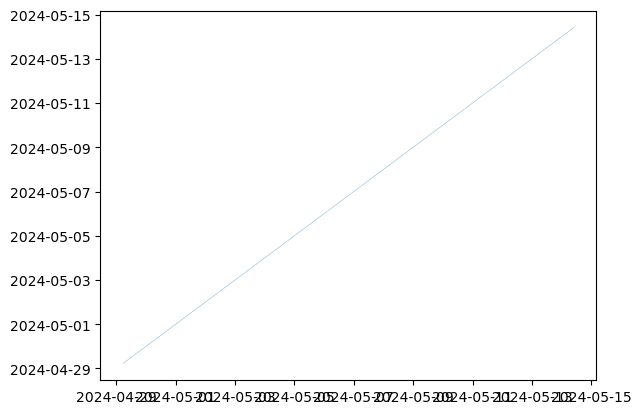

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x6847f97b0>

In [17]:
plot(vndt1[rr], gps2dt.(Vn1[:GpsTime][rr]), linewidth=0.2)

## leg 2 timing

In [29]:
# read leg 2 VectorNav data

# don't mind wrong datestamp on filename
datadir = joinpath(homedir(), "Data/EKAMSAT/lidar/table/")
file = joinpath(datadir, "leg2", "VectorNavData2023_04_30.txt")
# Vn2 = read_vecnav_dict( file ) # 65 s
# shorter than the leg 1 file for some reason
gps2dt.(Vn2[:GpsTime][[1 end]])
Vn2

Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.018898, 0.029153, 0.01625, 0.007101, -0.090097, 0.01…
  :Roll      => Float32[0.607903, 0.639943, 0.660012, 0.684908, 0.720244, 0.738…
  :Latitude  => Float32[12.1549, 12.1549, 12.1549, 12.1549, 12.1549, 12.1549, 1…
  :Yaw       => Float32[-93.161, -93.1778, -93.1731, -93.166, -93.181, -93.1912…
  :time      => [DateTime("2023-05-01T09:18:40"), DateTime("2023-05-01T09:18:40…
  :VelNED1   => Float32[0.0, -0.182795, -0.182172, -0.181728, -0.212629, -0.216…
  :MagNED2   => Float32[-0.017133, -0.018476, -0.015742, -0.013976, -0.012535, …
  :Altitude  => Float32[-64.517, -64.482, -64.482, -64.482, -64.475, -64.475, -…
  :Quat1     => Float32[-0.004427, -0.00461, -0.004749, -0.004888, -0.005049, -…
  :VelNED2   => Float32[0.0, -0.180361, -0.180657, -0.179543, -0.187947, -0.187…
  :MagNED0   => Float32[0.031774, 0.032013, 0.031541, 0.032001, 0.031873, 0.034…
  :Quat0     => Float32[0.00304, 0.003253, 0.003361, 0.003531, 0.003808, 0

In [20]:
# interpolate VectorNav datetimes between seconds
precdt2 = precise_dt(Vn2[:time], Vn2[:GpsTime])
# linear time coordinate with minimal bias compared to GPS
# vndt = stretch_vn_to_gps(precdt, Vn2[:GpsTime])

vndt2 = f( Vn2 ) # works for leg 2, fails for leg 1

# test agreement:
[precdt2[1:5], gps2dt.(Vn2[:GpsTime][1:5])]
length(vndt2)

16803458

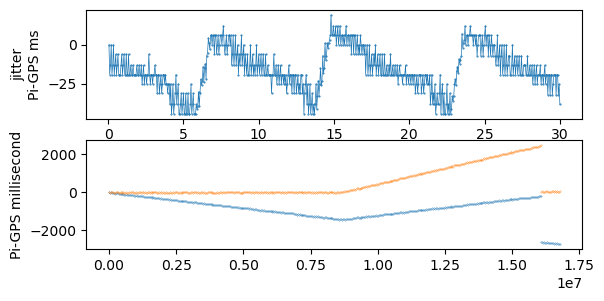

PyObject Text(24.0, 0.5, 'Pi-GPS millisecond')

In [22]:
# test plots of timing, leg 2
clf()
subplot(3,1,1)
plot((1:600)/20, DVM(precdt2[1:600] .- gps2dt.(Vn2[:GpsTime][1:600])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")

subplot(3,1,2)
rr = 1:(20*1800):length(vndt2)
plot(rr, DVM(precdt2[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
plot(rr, DVM(vndt2[rr] .- gps2dt.(Vn2[:GpsTime][rr])), label="adjusted", linestyle="none", marker=".", markersize=0.5)
# plot( DVM(precdt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
# plot( DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
ylabel("Pi-GPS millisecond")
# looks like leg 1

# # # when does the max offset occur, where the offset starts increasing?
# agm = argmin(precdt2[rr[200:300]] .- gps2dt.(Vn2[:GpsTime][rr[200:300]]))
# precdt[rr[250+agm-1]]  # 2024-06-07T08:24:01.048 also doesn't ring a bell
# minimum(DVM(precdt[rr[1:300]] .- gps2dt.(Vn2[:GpsTime][rr[1:300]]))) # 1.46 s

## legs 1 and 2 data

In [39]:
# concatenate legs 1 and 2

# if false
# read both VectorNav files and concatenate the data
# files = [ joinpath(datadir, "leg1", "VectorNavTableData.txt"),
#           joinpath(datadir, "leg2", "VectorNavData2023_04_30.txt") ]
# Vn = read_vecnav_dict( files )
# end

Vn = cat_dicts(Vn1, Vn2)
# make the whole time axis from the 2 legs

vndt = [vndt1; vndt2]

42870733-element Vector{DateTime}:
 2024-04-29T05:25:42.128
 2024-04-29T05:25:42.178
 2024-04-29T05:25:42.228
 2024-04-29T05:25:42.278
 2024-04-29T05:25:42.328
 2024-04-29T05:25:42.378
 2024-04-29T05:25:42.428
 2024-04-29T05:25:42.478
 2024-04-29T05:25:42.528
 2024-04-29T05:25:42.578
 2024-04-29T05:25:42.628
 2024-04-29T05:25:42.678
 2024-04-29T05:25:42.728
 ⋮
 2024-06-10T23:25:22.222
 2024-06-10T23:25:22.272
 2024-06-10T23:25:22.322
 2024-06-10T23:25:22.372
 2024-06-10T23:25:22.422
 2024-06-10T23:25:22.472
 2024-06-10T23:25:22.522
 2024-06-10T23:25:22.572
 2024-06-10T23:25:22.622
 2024-06-10T23:25:22.672
 2024-06-10T23:25:22.722
 2024-06-10T23:25:22.772

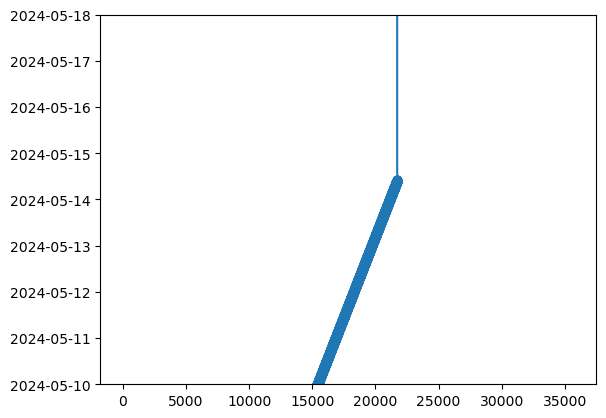

(19853.0, 19861.0)

In [24]:
plot(gps2dt.(Vn[:GpsTime][1:1200:end]), marker="o")
ylim([Date(2024,5,10), Date(2024,5,18)])
# leg 1 ends before Date(2024,5,15)

TO DO: Synchronize pitch angles or accels with the pitch from the POSMV.

## load POSMV

In [128]:
# get ship heading from POSMV
msg = "PASHR"
navdir = joinpath(homedir(), "Data/EKAMSAT/scs/NAV")
dt = DateTime(2024,4,30)
files = ShipPosmv.get_posmv_file(msg, Date(dt):Day(1):Date(dt)+Day(50); path=navdir )
# collect(files) # works!

# read ship heading - 34s for both legs
Pashr = ShipPosmv.read_pashr_dict( collect(files) ) # must collect(files)
keys(Pashr)

KeySet for a Dict{Symbol, Any} with 13 entries. Keys:
  :ins_Status_flag
  :heading
  :checksum
  :time
  :gps_update_qualiy_flag
  :pitch_accuracy
  :trueheading
  :heading_accuracy
  :heave
  :gpstime
  :roll
  :pitch
  :roll_accuracy

In [175]:
gyro1files = collect( ShipPosmv.get_nav_file("GYRO-01", "HDT" ,Date(dt):Day(1):Date(dt)+Day(50); path=navdir ) )
Gyro1 = ShipPosmv.read_gyro_dict( gyro1files )
gyro2files = collect( ShipPosmv.get_nav_file("GYRO-02", "HDT" ,Date(dt):Day(1):Date(dt)+Day(50); path=navdir ) )
Gyro2 = ShipPosmv.read_gyro_dict( gyro2files )

/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240430-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240501-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240502-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240503-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240504-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240505-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240506-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240507-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240508-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240509-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240510-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240511-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240512-000001.Raw/Users/deszoeks/Data/EKAMSAT/scs/NAV/GYRO-01-HDT-RAW_20240513-00

Dict{Symbol, Any} with 5 entries:
  :heading       => Union{Missing, Float32}[204.72, 204.59, 204.51, 204.59, 204…
  :checksum      => UInt8[0x1c, 0x15, 0x1d, 0x15, 0x10, 0x15, 0x16, 0x19, 0x10,…
  :nmeastring    => ["\$HEHDT", "\$HEHDT", "\$HEHDT", "\$HEHDT", "\$HEHDT", "\$…
  :headingistrue => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, …
  :time          => [DateTime("2024-04-30T00:00:01.730"), DateTime("2024-04-30T…

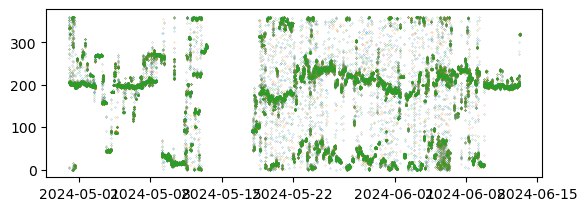

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x30bc3e920>

In [179]:
# test plot headings: POSMV, GYRO1, GYRO2 agree
subsampl=120
subplot(2,1,1)
plot(Pashr[:time][1:subsampl:end], Pashr[:heading][1:subsampl:end], marker=".", markersize=0.3, linestyle="none") # slow plot
plot(Gyro1[:time][1:subsampl:end], m2n.(Gyro1[:heading][1:subsampl:end]), marker=".", markersize=0.3, linestyle="none") # slow plot
plot(Gyro2[:time][1:subsampl:end], m2n.(Gyro2[:heading][1:subsampl:end]), marker=".", markersize=0.3, linestyle="none") # slow plot

# trueheading==1 means the heading is a "true heading"

In [26]:
# # interpolate using datetimes as coordinates

# interpolatedt(dt, x...) = interpolate(Dates.datetime2epochms(dt), x...)
# # usage:
# # itp(dtq) = interpolatedt(dtk, xk, Gridded(Linear()))(Dates.datetime2epochms(dtq))

# i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17) + 1

# define 2 ranges carefully to avoid out-of-range interpolation
i0 = 1

istp = 120
first1 = i0
last1 = findfirst(diff(Vn[:GpsTime]) .> 86400 * 1e9)
stop1 = (first1-last1)%istp + last1
rr1 = range(start=first1, step=istp, stop=stop1)

first2 = last1 + 1
last2 = length(Vn[:GpsTime])
stop2 = (first2-last2)%istp + last2
rr2 = range(start=first2, step=istp, stop=stop2)

# # define the interpolator ONCE OUTSIDE the wrapper function
# itp = interpolate( (gps2ms.(Vn[:GpsTime][i0:120:end]), ),
#                     Vn[:Yaw][i0:120:end], Gridded(Linear()) ) # returns a function
# # itp method accepts vectors as arguments
# """
# Interpolate VectorNav yaw to dt.
# Wrapper function converts DateTime to interpolatable time values and evaluates interpolation at dt::.
# """
# # wrapper function must internally broadcast on vector dt.
# VnYaw(dt; itp=itp) = itp(Dates.datetime2epochms.(dt))

# evaluate the interpolation at POSMV time step-wise with 2 interpolator functions
vn_yaw_dt = NaN.+ zeros(size(Pashr[:heading][:])) # fill result with NaNs same size as POSMV Pashr
ii1 = findall( gps2dt(Vn[:GpsTime][first1])     .< Pashr[:time][:] .< gps2dt(Vn[:GpsTime][stop1]) )
itp1 = interpolate( (gps2ms.(Vn[:GpsTime][rr1]), ), Vn[:Yaw][rr1], Gridded(Linear()) ) # returns a function
vn_yaw_dt[ii1] = itp1(Dates.datetime2epochms.(Pashr[:time][ii1]))

ii2 = findall( gps2dt(Vn[:GpsTime][first2]) .< Pashr[:time][:] .< gps2dt(Vn[:GpsTime][stop2]  ) )
itp2 = interpolate( (gps2ms.(Vn[:GpsTime][rr2]), ), Vn[:Yaw][rr2], Gridded(Linear()) ) # returns a function
vn_yaw_dt[ii2[1:end-20]] = itp2(Dates.datetime2epochms.(Pashr[:time][ii2[1:end-20]])) # interpolate interpolatable times; fast no-problem

# vn_yaw_dt[ii2] = VnYaw(Pashr[:time][ii2])
# [ DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][last1])), DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][first2])) ]


1692752-element Vector{Float32}:
 -93.16737
 -93.17917
 -93.19176
 -93.20395
 -93.21575
 -93.22795
 -93.240524
 -93.252365
 -93.26455
 -93.277115
 -93.2893
 -93.30113
 -93.32381
   ⋮
 -98.27475
 -98.26628
 -98.258316
 -98.25011
 -98.24165
 -98.23369
 -98.22548
 -98.21702
 -98.16542
 -98.110306
 -98.05336
 -97.9946

In [27]:
# leg 2 start and end times

DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][first2])), DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][stop2]))

(DateTime("2024-06-01T04:18:42.098"), DateTime("2024-06-10T23:25:17.837"))

## compare POSMV time

In [86]:
# peek to see how PASHR gps time is formatted
Pashr[:gpstime][1:4], Pashr[:time][1:4]
any( (Pashr[:gpstime] .- Time.(Pashr[:time])) .< Nanosecond(0)) # NOT always positive!
(Pashr[:gpstime] .- Time.(Pashr[:time])) .< Nanosecond(0)

DateTime.(Date.(Pashr[:time][1:5])) .+ Millisecond.(Pashr[:gpstime][1:5] .- Time.(Pashr[:time][1:5]))
DateTime.(Date.(Pashr[:time][end-5:end])) .+ Millisecond.(Pashr[:gpstime][end-5:end] .- Time.(Pashr[:time][end-5:end]))


true

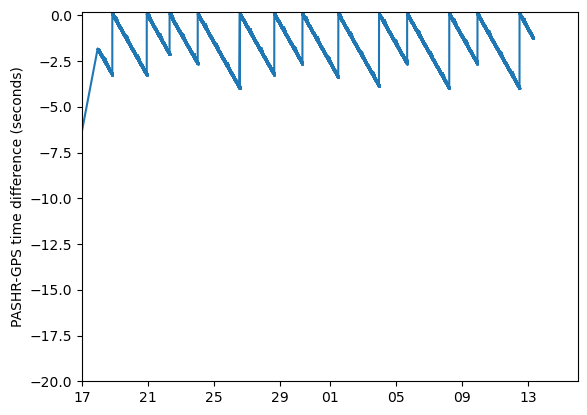

2-element Vector{DateTime}:
 2024-05-17T22:53:24.877
 2024-06-13T07:17:38.674

In [186]:
pashr_gpsdt = pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime])

plot(Pashr[:time][1:35:end], DVM(Pashr[:time].-pashr_gpsdt)[1:35:end]/1_000, marker=".", markersize=1 )#, linestyle="none") # slow
ylabel("PASHR-GPS time difference (seconds)")
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
xlim([DateTime(2024,5,17,0), DateTime(2024,6,16,0)])
ylim([-20, 0.2])
# shows jitter, GPS set ahead of POSMV by ~+80 ms, sometimes ~+160 ms.
Pashr[:time][[findfirst(Pashr[:time].>Date(2024,5,17)), end]]

leg 1: GPS runs faster than POSMV (about 1.6 s/day), running ahead up to 22.58 s by end of leg 2. GPS is never adjusted or reset in leg 1.

leg 2: GPS drifts ahead of POSMV at same rate as leg 1 and then resets to near POSMV-GPS +80, +120, or +160 ms every 1.5-2.5 days.

In [190]:
1300/DVM(diff(Pashr[:time][[findfirst(Pashr[:time].>Date(2024,5,17)), end]]))[1]
# If GPS updates are to be believed,
# POSMV has a good clock that's about 5.7e-7:1 slow. 
# It loses about 1.3 second over the whole of leg2.
# Could add this to the clock to speed it up.
# Agreeing within a second would be great.
# Leg 1 there is no GPS timing correction, so we don't know the offset.
# Leg 2 apparently is synced and agrees very well with the GPS.

5.710134767583198e-7

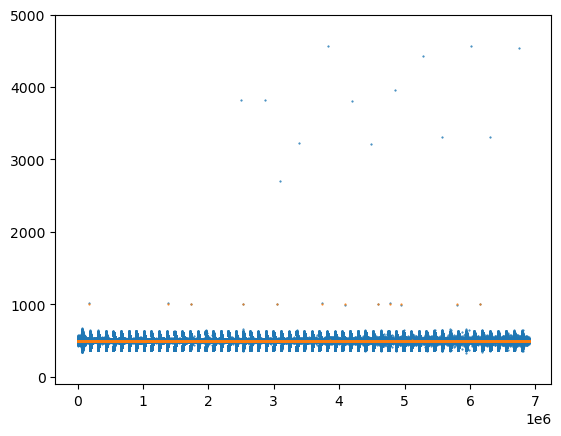

26-element Vector{Int64}:
      1016
      1015
      1000
 378574746
      3818
      1000
      3819
      1000
      2696
      3227
      1015
      4572
       985
      3804
      3214
      1000
      1016
      3955
       985
      4424
      3307
       985
      4571
      1000
      3311
      4543

In [126]:
minimum(DVM(Pashr[:time].-pashr_gpsdt)/1_000)
plot(DVM(diff(Pashr[:time])), marker=".", markersize=1, linestyle="none")
plot(DVM(diff(pashr_gpsdt)), marker=".", markersize=1, linestyle="none")
ylim([-100, 5000])
sum(DVM(diff(pashr_gpsdt)) .== 1000) # 11 exactly 1 s
DVM(diff(pashr_gpsdt))[DVM(diff(pashr_gpsdt)) .> 1000]
# 12 single skipped timesteps, 1 hiatus between legs

DVM(diff(Pashr[:time]))[DVM(diff(Pashr[:time])) .> 900]

GPS gets behind and then skips ahead. 
GPS clock is not that great (falls behind compared to POSMV), but gets
updated to agree with POSMV. POSMV timestamp is just fine. The GPS isn't good enough to correct it. 

The GPS increments overshoot by 80 ms, etc., suggesting that the POSMV also runs slightly too fast.

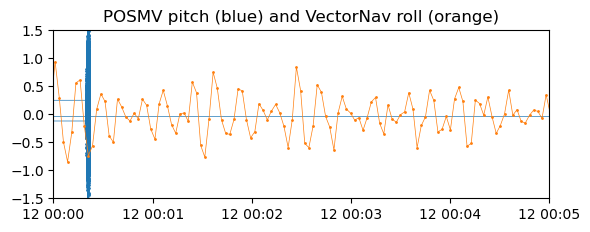

PyObject Text(0.5, 1.0, 'POSMV pitch (blue) and VectorNav roll (orange)')

In [83]:
i0 = 1
df = dateformat"yyyy-mm-dd"
subsampl = 5

clf()
subplot(2,1,1)
plot(pashr_gpsdt[1:subsampl:end], Pashr[:pitch][1:subsampl:end].-0.2, label="POSMV", marker=".", markersize=2, linewidth=0.5)
plot(vndt[1:(10*subsampl):end], Vn[:Roll][1:(10*subsampl):end].+0.4, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,5,12,0,0,0), DateTime(2024,5,12,0,5,0)])
ylim([-1.5, 1.5])
title("POSMV pitch (blue) and VectorNav roll (orange)")

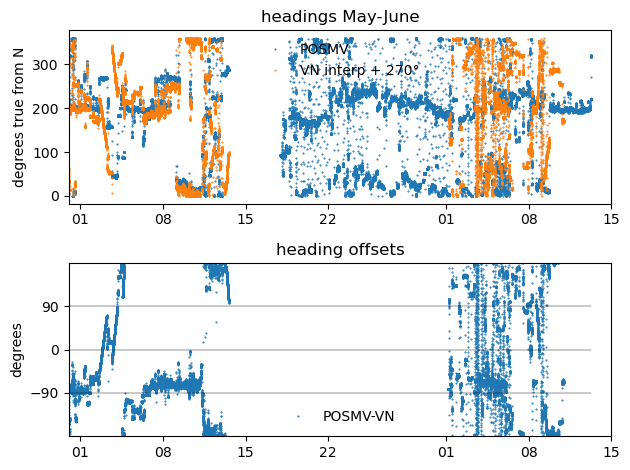

In [116]:
# plots compare UND VectorNav to POSMV ship heading, find offsets
i0 = 1
df = dateformat"yyyy-mm-dd"
subsampl = 120
uwrap(t) = ((t+180) % 360) - 180

clf()
subplot(2,1,1)
plot(Pashr[:time][1:subsampl:end], Pashr[:heading][1:subsampl:end], label="POSMV", marker=".", markersize=1, linestyle="none")
# plot(gps2dt.(Vn[:GpsTime][i0:subsampl0:end]), (Vn[:Yaw][i0:subsampl0:end].+270.0).%360, label="VN + 270°", marker=".", markersize=1, linestyle="none")
plot(Pashr[:time][1:subsampl:end], (vn_yaw_dt[1:subsampl:end].+270) .% 360, label="VN interp + 270°", marker=".", markersize=1, linestyle="none")
xlim(Date(Pashr[:time][1]).+Day.([0, 46]))
legend(frameon=false)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
# title("headings $(Dates.format(Pashr[:time][1],df))")
title("headings May-June")
ylabel("degrees true from N")

subplot(2,1,2)
plot(Pashr[:time][1:subsampl:end], uwrap.(Pashr[:heading].-vn_yaw_dt)[1:subsampl:end], label="POSMV-VN", marker=".", markersize=1, linestyle="none")
plot(Pashr[:time][[1, end]], [-90, -90], color="k", linewidth=0.3)
plot(Pashr[:time][[1, end]], [0, 0], color="k", linewidth=0.3)
plot(Pashr[:time][[1, end]], [90, 90], color="k", linewidth=0.3)
xlim(Date(Pashr[:time][1]).+Day.([0, 46]))
legend(frameon=false)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
yticks(-90:90:90)
title("heading offsets")
ylabel("degrees")
ylim([-180, 180])

tight_layout()


At first, the UND lidar table VectorNav is pointed about 90° to the right (to startboard) of the ship's coordinate system, resulting in VectorNav heading mostly +90° greater than the ship's true heading. The GPS solution seems to depend on the heading itself.

The mean alignment shifts so that the VN points forward of starboard May 2.
It completes nearly a full turn from its initial positon May 5.


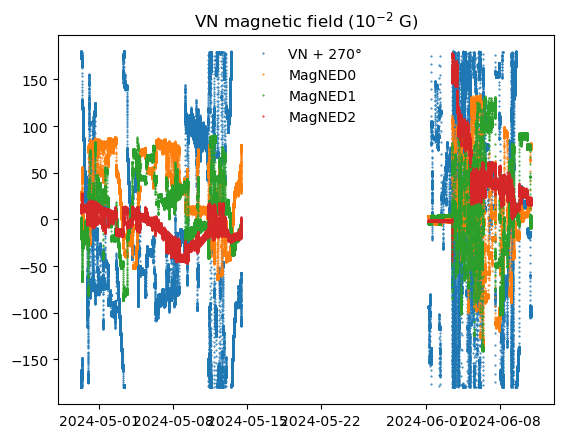

PyObject <matplotlib.legend.Legend object at 0x931401810>

In [124]:

# magnetometer (gauss)
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), (Vn[:Yaw][i0:subsampl:end]), label="VN heading", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED0][i0:subsampl:end]), label="MagNED0", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED1][i0:subsampl:end]), label="MagNED1", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED2][i0:subsampl:end]), label="MagNED2", marker=".", markersize=1, linestyle="none")
title("VN magnetic field (10\$^{-2}\$ G)")
ylim([-180, 180])
legend(frameon=false)

In [22]:
bigread = false

if bigread
    # precompile reader on a short file
    datadir = joinpath(homedir(), "Data/EKAMSAT/lidar/table")
    file = joinpath(datadir, "VNshort.txt") #"VectorNavTableData.txt")
    @time test = read_vecnav_dict( file ) 
    @time test = read_vecnav_dict( file ) 

    # process the big read Vn data
    @time Vn = read_vecnav_dict( file ) # very big slow read takes 2:27; !compile first!
    # study time index
    plot(Vn[:GpsTime][1200:1200:end], marker=".", linestyle="none") # jumps
    plot(Vn[:time][1200:1200:end], marker=".", linestyle="none") # monotonic
    i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17) + 1
    # i0=663 # first good index of big Vn structure

    # diff(Vn[:GpsTime][700:712]) # integer nanoseconds = 10-9 s
    # 50_000_000 ns is 0.05 s


    # gps2dt(gpstime::Vector) = gps2dt.(gpstime)

    # fix the time
    delete!(Vn, :time)
    Vn[:time] = gps2dt.(Vn[:GpsTime]) # re-add

    # # time interpolator, truncates
    # itp_vn(k, t) = interpolate(Dates.value.(Vn[:time][i0:end]), Vn[k][i0:end])[t]

    # write in a big mat file - no offsets
    matopen("VectorNavTable.mat", "w") do matfile
        # Write the variables to the MAT file
        write(matfile, "time_offset", Dates.value.(Vn[:time][i0:end] .- Vn[:time][i0])) # millisec since base_time
        write(matfile, "base_time",  Dates.format( Vn[:time][i0], "yyyy-mm-dd HH:MM:SS.sss" ))
        for k in filter(k -> k !== :time, keys(Vn)) # write the rest of the variables
            write(matfile, String(k), Vn[k][i0:end])
        end
        close(matfile)
    end

    # write 1 JLD2 file - no offsets
    jldopen("VectorNavTable.jld2", "w") do file
        # Write the VectorNav dict to the JLD2 file
        # no time offsets
        file["Vn"] = Vn
    end

    # read 1 big JLD2 file 
    jldopen("VectorNavTable.jld2", "r") do file # subsetting while reading saves no time
        vn_dt = file["Vn"][:time]
        pitch = file["Vn"][:Pitch]   # degrees 
        roll  = file["Vn"][:Roll]    # degrees
        heave = file["Vn"][:VelNED2] # m/s
    end

    # save smaller subsets as daily files for easier reading
    days = unique(Date.(Vn[:time][i0:end]))

    for d in days
        # st = maximum(i0, findfirst(t -> t >= d, vn_dt ))
        st = findfirst(t -> t >= d       , Vn[:time] ) # no offsets
        en = findlast( t -> t <  d+Day(1), Vn[:time] )
        yyyymmdd = Dates.format(d, dateformat"yyyymmdd")

        jldopen(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"), "w") do file
            # Write the VectorNav dict to the JLD2 file
            file["time"]  = Vn[:time ][st:en]
            file["pitch"] = Vn[:Pitch][st:en]
            file["roll"]  = Vn[:Roll ][st:en]
            file["heave"] = Vn[:VelNED2][st:en]
        end
    end

end

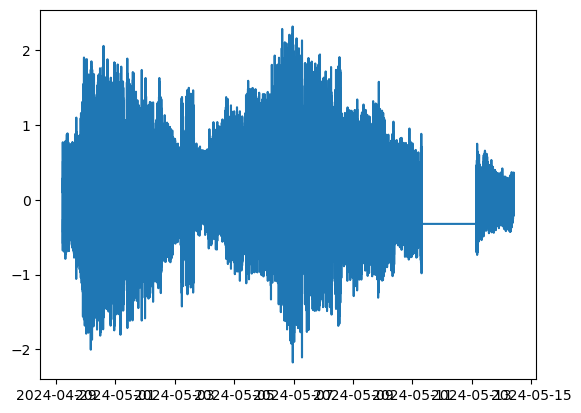

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7d0855750>

In [10]:
# read whole big JLD2 file, look at heave
file = jldopen("VectorNavTable.jld2", "r") # subsetting while reading saves no time
    vn_dt = file["Vn"][:time]
    pitch = file["Vn"][:Pitch]   # degrees 
    roll  = file["Vn"][:Roll]    # degrees
    heave = file["Vn"][:VelNED2] # m/s
close(file)

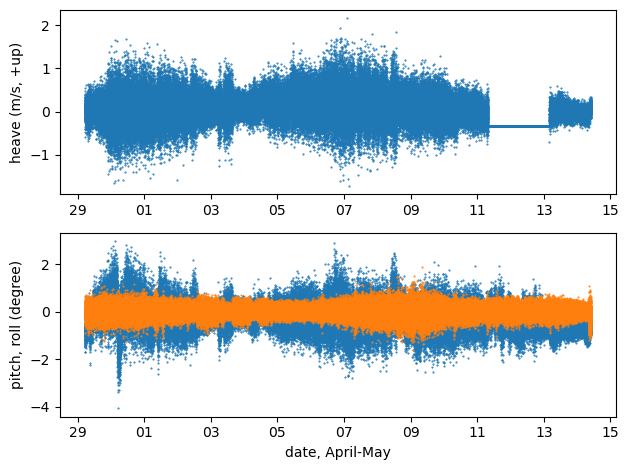

In [19]:
ii = vn_dt .> Date(2000,1,1)
date_formatter = PyPlot.matplotlib.dates.DateFormatter("%d") # "%Y-%m-%d"

subplot(2,1,1)
plot(vn_dt[ii][1:200:end], -heave[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
ax=gca()
ax[:xaxis][:set_major_formatter](date_formatter)
ylabel("heave (m/s, +up)")

subplot(2,1,2)
plot(vn_dt[ii][1:200:end],  roll[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
plot(vn_dt[ii][1:200:end], pitch[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
ax=gca()
ax[:xaxis][:set_major_formatter](date_formatter)
ylabel("pitch, roll (degree)")
xlabel("date, April-May")

tight_layout()
savefig("leg1_VN_heave_pitch.png")

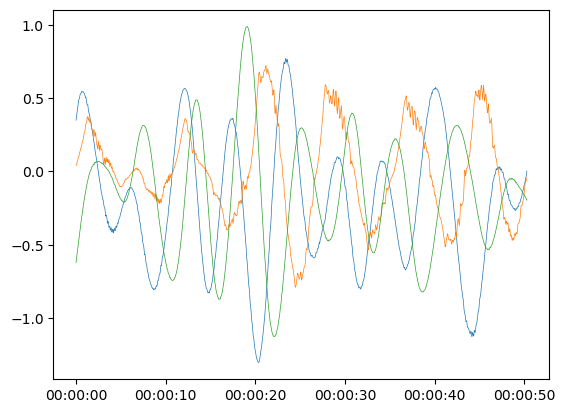

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3493bffd0>

In [16]:
# read daily JLD2 example
dt = DateTime(2024, 5, 8)
yyyymmdd = Dates.format(dt, dateformat"yyyymmdd")
Vn = JLD2.load(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"))

st = 1; en = 1000
plot(Vn["time"][st:en], Vn["roll"][st:en], linewidth=0.5) # RollPitchYaw in degrees
plot(Vn["time"][st:en], Vn["pitch"][st:en], linewidth=0.5)
plot(Vn["time"][st:en], Vn["heave"][st:en], linewidth=0.5) # heave of the body in NED frame in m/s

## find displacements of sample volumes

In [24]:
rangegate = 24
range = 12.0 .+ 24.0.*((1:150).-1) # conflicts with Base.range

#=
heave = Vn[:VelNED2] # m/s?

# trigonometry to find displacements between volumes to be used in structure functions
target_vector(range, pitch, roll) = range .* [ -sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll) ]
#simultaneous_vector(a1,a2, p1,p2, r1,r2) = target_vector(a1,p1,r1) .- target_vector(a2,p2,r2)
displacement_vector(X, Y, a1,a2, p1,p2, r1,r2) = [X, Y, 0] .- (target_vector(a1,p1,r1) .- target_vector(a2,p2,r2))
rad = abs(displacement_vector)
r1 = abs(displacement_vector[1])

function df(f, x::Vector)
    y = 
    for i = axes(x)
        for j = axes(x)[1:end]
            y = f( x[i] - x[j] )
        end
    end
    return y
end

"efficient representation of interaction of difference of vector u members"
Df(u) = UpperTriangular( (u .- permutedims(u)) )

# vectorize 3 levels of w
D2w = Df(w).^2
dx  = Df(x)
dy  = Df(y)
dz  = Df(z)
dist3 = norm()
=#

12.0:24.0:3588.0

In [19]:
#=
# address the time,height series with CartesianIndices?
ntime = 1000
nz = 150
nzoffset = 3
nind = ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2)

function displacements_housekeeping(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    ntime = 1000
    nz = 150
    nzoffset = 3
    nind = round(Int64, ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2))
    
    # first housekeeping pass to estimate indices and displacements without data
    # and no angular corrections

    I = Vector{CartesianIndex{2}}(undef, nind)
    J = Vector{CartesianIndex{2}}(undef, nind)
    fill!(I, CartesianIndex(0,0))
    fill!(J, CartesianIndex(0,0))

    zm = Vector{Union{Missing,Float32}}(missing, nind)
    dz = Vector{Union{Missing,Float32}}(missing, nind)
    dr = Vector{Union{Missing,Float32}}(missing, nind)
    
    pitch = 0
    roll = 0
    X = 0.5
    Y = 0.5

    lin = 0 
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    lin += 1
                    # I is first point, J is second point
                    I[lin] = CartesianIndex(it,iz)
                    J[lin] = CartesianIndex(it,jz)
                    zm[lin] = (range[iz] + range[jz]) / 2
                    dz[lin] =  range[iz] - range[jz]
                    dx = X
                    dy = Y
                    # distance between
                    dr[lin] = dz[lin]*dz[lin] + dx*dx * dy*dy
                end
            end
        end
    end

    return I,J, zm, dz,dr, lin
end

I,J, zm, dz,dr, lin = displacements_housekeeping()
# still not sure I'm counting the pairs correctly
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 2), CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], CartesianIndex{2}[CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5), CartesianIndex(1, 6), CartesianIndex(1, 6), CartesianIndex(1, 7)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], Union{Missing, Float32}[24.0f0, 36.0f0, 48.0f0, 60.0f0, 72.0f0, 84.0f0, 96.

In [216]:
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time, range
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works


4498500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [20]:
# It might be fast enough to just move the pairing window up by 1 each time.
# But this will repeat some sample pairs: pairs in adjacent lines 2x, and in the same line 3x.
# To fix this, compute the unique set of pairs l1,l2 for the whole set of CartesianIndices 
# including z indices 1:nz. Then filter for the z index of ci[l2] to be <=3 from ci[l1].
# Generating this many pair is awfully slow. 
# There's no overlap if we generate pairs in sets of 3 levels, and go back to fill
## ci = CartesianIndices((nt,nz)) ## too slow

nt = 1000
nc = 3
islide = 0
# ci = CartesianIndices((nt,nc)) .+ CartesianIndex((0, islide))
# li = LinearIndices(ci)
# lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ] # redundancy

# The complete set that doesn't repeat pairs is 
# 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
# 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
# Iteratively slide this box upward by 1 level for each level.
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# index pairs in middle level 2-2
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

# index pairs of points from level 2-1, and 2-3
ac = allcross(nt)
it1 = map(i->i[1], ac)
it2 = map(i->i[2], ac)
ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
ci2_r21 = CartesianIndex.(tuple.(it2,1))
ci2_r23 = CartesianIndex.(tuple.(it2,3))

# omnibus set of cartesian index pairs for a level, including points in lev above and below
ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
ci2 = [ci2_r23; ci2_r22; ci2_r21]
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

2499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
       1
       2
       3
       4
       5
       6
       7
       8
       9
      10
      11
      12
      13
       ⋮
 2499489
 2499490
 2499491
 2499492
 2499493
 2499494
 2499495
 2499496
 2499497
 2499498
 2499499
 2499500

In [74]:
# just use one level
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

# set of cartesian index pairs for a level, including points in lev above and below
ci1 = ci1_r11 # first of pairs
ci2 = ci2_r11
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
      1
      2
      3
      4
      5
      6
      7
      8
      9
     10
     11
     12
     13
      ⋮
 499489
 499490
 499491
 499492
 499493
 499494
 499495
 499496
 499497
 499498
 499499
 499500

In [75]:
it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second

499500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [76]:
# displacements with no adjustment for tilting into the horizontal wind 
# Udt, Vdt vary slowly; pitch,roll,w vary fast

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [77]:
# test the logic by computing with dummy data
nz = 150
w = zeros(nt,nz)
Udt = 5.0 .+ zeros(nz)
Vdt = 5.0 .+ zeros(nz)
pitch = @. 10*pi/180 * sin((1:nt)*pi/10) # fake
roll  = @. 10*pi/180 * cos((1:nt)*pi/10)

zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )


([11.817982128203518, 11.817982128203518, 11.817852842269513, 11.817772939208005, 11.817852842269513, 11.817982128203518, 11.817982128203518, 11.817852842269515, 11.817772939208005, 11.817852842269513  …  11.817982128203516, 11.817982128203516, 11.817852842269513, 11.817772939208005, 11.818111414137519, 11.817982128203516, 11.817902225142007, 11.817982128203516, 11.817902225142007, 11.817772939208005], [41.60892235148373, 165.56618916638564, 373.2530801612619, 669.3141843344615, 1060.9511284580296, 1556.997976965279, 2166.808405320483, 2898.900254753664, 3759.4234181093752, 4750.7572886879725  …  53.26818337860324, 207.41469221877617, 453.76540289876505, 784.54262777845, 50.45958740461272, 196.0943665565296, 428.95391361097325, 47.60838001704101, 185.1729869202623, 44.99943919594262], [6.685941092315753e-8, 6.685941092315753e-8, 3.1554436208840472e-30, 2.5537996954371423e-8, 3.1554436208840472e-30, 6.685941092315753e-8, 6.685941092315753e-8, 0.0, 2.5537996954371423e-8, 3.15544362088404

In [97]:
rho = rhopair.(dr2, dz2)
#plot((1:length(rho))/length(rho), sort(rho))

# devise equally-populated bins
nrho = length(rho)
nbin = 20
sp = sortperm(rho)
srho = rho[sp]
rhobins = [ 0; rho[sp[Int32(nrho/20):Int32(nrho/20):nrho]] ]
# maximum(rho), sort(rho)[length(rho)]
# plot(rhopair.(dr2, dz2), zm, marker=".", linestyle="none")
# hist(rhopair.(dr2, dz2), bins=20)

# bin average y in bins of x
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

D2bin = binavg(rand(length(rho)), rho, rhobins)

21-element Vector{Float64}:
   0.5011519448338186
   0.4999114056422025
   0.502889482573963
   0.5024909566945889
   0.5021074583191569
   0.4990818258293421
   0.5016916866736525
   0.5029742832878987
   0.4985054101735766
   0.5022302415769619
   0.4979960591945028
   0.5039502632839588
   0.5006210530627802
   0.5003313080284651
   0.5020551011563921
   0.5025498290622787
   0.5003079689029826
   0.5000752475035021
   0.49981572721669687
   0.5004674802523021
 NaN

In [ ]:

# plot some of this stuff
# drcount, bins = hist((dr[:]), bins=80, range=(30, (X*nt*1.4)))
dzcount, bins = hist((dz[:]), bins=80, range=(0, (2*24)))
title("displacement between point pairs")
clf()
plot(dz./dr, dz, marker=".", linestyle="none")


In [ ]:

    dz = Float32
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[jt])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

function displacements_D2(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[it1])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

# I don't know how to do this with CartesianIndices
I = CartesianIndices([(it, iz) for iz=1:nlev-2, it in 1:ntime]) # seems OK
J = I + CartesianIndex(1:ntime-1, )

In [ ]:

#=
% turbulece constants
crosscomp  = 3 / 4;
kolmogorov = 0.54; % Matches atmospheric boundary layer estimates and Sreenivasan 1995
% kolmogorov=0.5; % probably only 1 digit of precision, Sreenivasan 1995
C1prime = 4 / 3 * kolmogorov; % as in Pope eqn 6.243
factr   = crosscomp / kolmogorov; % 1/C1prime, used for my dissipation calculation
% S(w; k) = C1primt * epsilon^2/3 k^-5/3
% universal constant for 2nd order structure function
% longitudinal structure function constant C2 from Pope 6.2 (p.193) after Saddoughi and Veeravalli (1994)

factrz = 1 / C2ll;
factrx = 3 / 4 / C2ll;
=#

# stucture function
C2ll = 2.0
struf(epsilon, r,r1) = C2ll epsilon^(2/3) r^(2/3) (4 - (r1/r)^2)/3
instruf(w1,w2) = (w1-w2)^2
rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)
epsilon(A) = sqrt(3/4 * A/C2ll)^3